# VAD

In [1]:
# Este comando \\\"limpia\\\" todas las variables definidas (equivalente a clear all de Matlab)
%reset_selective -f b

# Este comando le indica a Python que las figuras se deben generar dentro de la misma Notebook, no en una ventana
%matplotlib inline

import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import numpy as np
import glob
import pyart
import pandas
import scipy
import csv
import LowPassFilter
import RadarBeamPropagation
import radarfun


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Leemos los datos



In [2]:
#Elejimos si queremos trabajar con 120km o con 240km

rango = '120/'

path_user = '../../Radar/VAD/PARANA/20160114/' + rango

FileList = np.sort(glob.glob(path_user+'*.nc'))
#FileList = np.sort(glob.glob(path_user + 'PARANA/20160123/20160123/cfrad.20160123_060001.000_to_20160123_060427.000_INTA_Parana_SUR.nc'))
file2read=FileList[0]

print FileList
# Creamos el objeto "radar"
#radar = pyart.io.read(file2read)

[ '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_115432.000_to_20160114_115730.000_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_120433.000_to_20160114_120731.000_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_121435.000_to_20160114_121733.000_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_122433.000_to_20160114_122730.000_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_123433.000_to_20160114_123731.000_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_124456.000_to_20160114_124732.999_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_125433.000_to_20160114_125732.444_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_130433.000_to_20160114_130731.000_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/120/cfrad.20160114_131436.000_to_20160114_131734.001_INTA_Parana_SUR.nc'
 '../../Radar/VAD/PARANA/20160114/12

Veamos cuantos ángulos de elevaciones tenemos

In [12]:
# Angulos de elevación
rango = '120/' #Elejimos con que rango queremos trabajar
path_user = '../../Radar/VAD/PARANA/20160114/'
FileList = np.sort(glob.glob(path_user+'*.nc'))
#file2read = FileList[0]
radar = pyart.io.read(file2read)
elev_ang = np.unique(radar.elevation['data'])
print(elev_ang)
print elev_ang.size -1


[  0.5          1.29999995   2.29999995   3.5          5.          11.80000019
  15.10000038  19.20000076]
7


## Empezamos con el cálculo

In [16]:
# Leemos los archicos .nc
rango = 'prueba/' #Elejimos con que rango queremos trabajar
path_user = '../../Radar/VAD/PARANA/201601231/' + rango
FileList = np.sort(glob.glob(path_user+'*.nc'))



# Parametros

field  = 'Vda'    #Nombre de la variable en el archivo de datos
angmin = 2        #Ángulo de elevación mínimo expresado como indice y empezando en 0
angmax = 6       #Ángulo de elevación máximo expresado como indice
rint   = 0.3      #Radio interior de la arandala a calcular en Km
rext   = 40.0     #Radio exterior de la arandela a calcular
maxgap = 30       #Máximo gap sin datos permitido, en grados
maxNaN = 72       #Cantidad de de datos faltantes en un anillo
rmin   = 0.8      #R cuadrado mínimo para que el fit del anillo sea válido
lpf    = 'False'  #Usa o no filtro pasa bajo
N      = 12       #Cantidad de datos a usar en el filtro, tiene que ser par!

# Arranca el cálculo para cada archivo y angulo de elevación
#===========================================================

for f in range(len(FileList)):
    
    file2read=FileList[f]

    # Creamos el objeto "radar"
    radar = pyart.io.read(file2read)

    # Algunas variables que necesito
    elev_ang  = np.unique(radar.elevation['data'])
    angmax = elev_ang.size -1
    nelev     = np.arange(angmin, angmax, 1) 
    rings     = np.zeros(shape=(len(elev_ang),2))
    rings[:,1] = elev_ang
    rango = radar.range['data']
    r        = (radar.range['data'])/1000 #En km
    DateTime = radar.metadata['start_datetime']
    NameRadar= radar.metadata['site_name']

    #Inicializo los arrays que van a guardar las variables spd, di, SEspd, SEdi con NaNs
    spd   = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    di    = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    SEspd = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    SEdi  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    spd_up = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    spd_dw = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    di_up = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    di_dw = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    var   = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    rmse  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    elev  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    a  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    b  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan
    rs  = np.zeros(shape=(len(rango),len(elev_ang)))*np.nan

    #Calculo la propagación del haz
    [r, ht, rh, lea]  = RadarBeamPropagation.propagation(r, elev_ang, plot = 'False')

    #Fijo el ángulo de elevación
    for j in nelev:
        start_index = radar.sweep_start_ray_index['data'][j]
        end_index   = radar.sweep_end_ray_index['data'][j]

        tiempo  = radar.time['data'][start_index:end_index]
        azimuth = radar.azimuth['data'][start_index:end_index]
        Vda_raw = pandas.DataFrame(radar.fields[field]['data'][start_index:end_index], index=azimuth, columns=rango)
        cos_phi = np.cos((azimuth*np.pi)/180)
        sin_phi = np.sin((azimuth*np.pi)/180)
        elev    = elev_ang[j]
        countrings = 0


        for i in range(len(rango)): #Revisa cada gate

            #Subset para hacer VAD en una arandela de radio interior = rint y exterior = rext
            if (rh[i,j] < rint) | (rh[i,j] > rext):
                continue

            # Control de calidad de los datos 
            ## Errores aleatorios => Filtro pasa bajo

            if lpf == 'True':

                temp_Vda = np.array(Vda_raw.iloc[:,i]) #Tomo los datos de un anillo o  gate
                Vda = LowPassFilter.lowpassfl(temp_Vda, N) #Pasa por el filtro si corresponde

            else:
                Vda = Vda_raw.iloc[:,i] #Si no pasa por el filtro, solo extraigo la información para el modelo

            #Lo convierto a un DataFrame porque ols usa este tipo de formato
            temp    = pandas.DataFrame({'Vda':Vda, 'cosphi':cos_phi, 'sinphi':sin_phi})

            ## Cantidad de datos por anillo

            if temp.isnull().sum().Vda > maxNaN:
                #print 'muchos NaNs en anillo %s' % (i) 
                continue

            ## Gaps en cada anillo

            countNaN = 0
            for k in range(len(Vda)):
                if Vda_raw.isnull().iloc[k,i]:
                    countNaN = countNaN + 1
                    if countNaN == maxgap:
                        #print 'gap muy grande en anillo %s' % (i) 
                        continue
                else: countNaN = 0
            #print 'anillo %s válido' % (i)   
            countobs = 360 - temp.isnull().sum().Vda

            # Ahora ajusto los datos a Vr = a0 + a1cos phi + b1 sin phi

            mod     = ols('Vda ~ cos_phi + sin_phi', temp).fit()

            countrings = countrings + 1
            #print(mod.summary())

            ## Extraigo los coeficientes y sus errores estandar
            a0      = mod.params.Intercept
            a1      = mod.params.cos_phi
            b1      = mod.params.sin_phi
            rs1      = mod.rsquared
            Vda_mod = a0 + a1*cos_phi + b1*sin_phi
            a[i,j] = a1
            b[i,j] = b1
            rs[i,j] = rs1

            ## Varianza según RadxEvad
            var[i,j]= (np.sum(np.power(temp.Vda-Vda_mod,2)))/(countobs-3)
            rmse[i,j]= np.sqrt(var[i,j])
            SEa1    = mod.bse.cos_phi
            SEb1    = mod.bse.sin_phi
            #MSEt     = mod.mse_model
            #RMSEt    = np.sqrt(MSEt)
            #u0      = b1/np.sin((elev*np.pi)/180)
            #v0      = a1/np.cos((elev*np.pi)/180)

            # Calculo el módulo y dirección del viento
            ## spd sale de Browning_and_Wexler pero no logro lograr la igualdad con el modulo, so...
            # Si el R cuadrado del modelo es menor al umbral, el anillo se descarta
            if (rs1 > rmin):
                spd[i,j]    = np.sqrt(np.power(a1,2) + np.power(b1,2))/np.cos((elev*np.pi)/180)
            
            #spd     = np.sqrt(np.power(u0,2) + np.power(v0,2))

            if (b1 < 0):
                di[i,j] = (np.pi/2 - np.arctan(a1/b1))*180/np.pi #Lo paso a grados
                di_up[i,j] = (np.pi/2 - np.arctan((a1+SEa1)/(b1+SEb1)))*180/np.pi
                di_dw[i,j] = (np.pi/2 - np.arctan((a1-SEa1)/(b1-SEb1)))*180/np.pi
            else:
                di[i,j] = (3*np.pi/2 - np.arctan(a1/b1))*180/np.pi
                di_up[i,j] = (3*np.pi/2 - np.arctan((a1+SEa1)/(b1+SEb1)))*180/np.pi
                di_dw[i,j] = (3*np.pi/2 - np.arctan((a1-SEa1)/(b1-SEb1)))*180/np.pi

            # Calculos el error estandar para cada variable

            #SEspd[i,0]  = (abs(a1)*SEa1 + abs(b1)*SEb1)/np.sqrt(np.power(a1,2) + np.power(b1,2))*np.cos((elev*np.pi)/180) 
            #SEdi[i,0]   = (abs(a1)*SEb1 + abs(b1)*SEa1)/np.sqrt(np.power(a1,2) + np.power(b1,2))
            #Error: calculado como 2*SE de cada parámetro, cual intervalo de confianza
            #spd_up[i,j]  = np.sqrt(np.power((a1+2*SEa1),2) + np.power((b1+2*SEb1),2))/np.cos((elev*np.pi)/180) 
            #spd_dw[i,j]  = np.sqrt(np.power((a1-2*SEa1),2) + np.power((b1-2*SEb1),2))/np.cos((elev*np.pi)/180) 
            #MSE[i,j]    = MSEt
            #RMSE[i,j]   = np.sqrt(MSEt)
        rings[j,0] = countrings
        #print countrings

    # Guardo todo en un data frame bonito
    spd = spd.flatten('F')
    rmse = rmse.flatten('F')
    di = di.flatten('F')
    rh = rh.flatten('F')
    ht = ht.flatten('F')
    e = np.repeat(elev_ang, len(rango), axis=0)
    elev = e.reshape([len(elev_ang), len(rango)]).transpose()
    elev = elev.flatten('F')
    a = a.flatten('F')
    b = b.flatten('F')
    rs = rs.flatten('F')
    vad = pandas.DataFrame({'spd':spd, 'rmse':rmse, 'di':di, 'rh':rh, 'ht':ht, 'elev':elev, 'a':a, 'b':b, 'rs':rs})

    vad.to_csv('Validacion/elev_vda-'+ DateTime + '_' + NameRadar + '.csv', sep = ';', na_rep = '-9999')
    #Muestra por pantalla la cantidad de anillos válidos para cada ángulo de elevación
    
    #Calculo del perfil final
    #========================
    
    # Parámetros
    minlev = 0.1  #Nivel inferior en kilometros
    maxlev = 3.0  #Nivel superior en kilometros
    deltalev = 0.1 #Intervalo de la grilla

    # Generamos la grilla del perfil
    pnlevs = ((maxlev - minlev)/deltalev)+1 #Cantidad de niveles

    pht = np.zeros(shape=(int(pnlevs),))*np.nan
    totalvad = pandas.DataFrame(np.zeros(shape=(int(pnlevs),7))*np.nan, columns = ['ht', 'spd', 'rmse', 'rmse2', 'rmse3', 'di', 'rings'])


    for l in range(int(pnlevs)):

        pht[l] = minlev + l * deltalev
        upperl = pht[l] + deltalev/2
        lowerl = pht[l] - deltalev/2

        #Subset de los datos que se encuentran en la capa
        temp = vad.loc[(vad.ht >= lowerl) & (vad.ht < upperl) & vad.spd  & (vad.spd.notnull())]
        #Cuento la cantidad de anillos válidos en la capa
        ringpl = len(temp.spd)

        #Calculo el promedio de spd para la capa
        
        w = temp.rmse + temp.rh
        if not w.any():
            continue

        spd_wavg = np.average(np.asarray(temp.spd), weights=np.asarray(w))
        di_wavg = np.average(np.asarray(temp.di), weights=np.asarray(temp.rh))

        #Calculo el RMSE
        var = sum(np.power(temp.spd-spd_wavg,2)/temp.rmse)/sum(1/temp.rmse)
        rmsec1 = var/np.sqrt(ringpl)
        rmsec2 = np.sqrt(1/(sum(1/np.power(temp.rmse,2))))
        rmsec3 = sum(np.power(temp.spd-spd_wavg,2)/np.sqrt(temp.rmse))/(sum(1/np.sqrt(temp.rmse))*(ringpl-1))

        #Guardo en el dataframe
        totalvad.ht[l] = pht[l]
        totalvad.spd[l] = spd_wavg
        totalvad.rmse[l] = rmsec1
        totalvad.rmse2[l] = rmsec2
        totalvad.rmse3[l] = rmsec3
        totalvad.di[l] = di_wavg
        totalvad.rings[l] = ringpl
    

    #Escribo un .csv que se guarda con la fecha y la hora del volumen de datos
    totalvad.to_csv('Validacion/vda-'+ DateTime + '_' + NameRadar + '.csv', sep = ';', na_rep = '-9999')

/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
/home/pao/anaconda2/lib/python2.7/site-packages/patsy/util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorica

In [14]:
angmax

4

# Contruimos el perfil

In [7]:
# Vamos a contruir el perfil final del viento a partir de todos los anillos válidos según los umbrales y condiciones
# impuestas mas arriba. La idea es definir una altura mínima, una máxima y el intervalo en el que quiero los datos
# Voy a querer obtener un valor de spd, dir y el RMSE para cada nivel. La idea es hacer un promedio pesado por el 
# RMSE y la distancia al radar (rh). 

# Parámetros
minlev = 0.1  #Nivel inferior en kilometros
maxlev = 3.0  #Nivel superior en kilometros
deltalev = 0.1 #Intervalo de la grilla

# Generamos la grilla del perfil
pnlevs = ((maxlev - minlev)/deltalev)+1 #Cantidad de niveles

pht = np.zeros(shape=(int(pnlevs),))*np.nan
totalvad = pandas.DataFrame(np.zeros(shape=(int(pnlevs),5))*np.nan, columns = ['ht', 'spd', 'rmse', 'di', 'rings'])



for l in range(int(pnlevs)):
    
    pht[l] = minlev + l * deltalev
    upperl = pht[l] + deltalev/2
    lowerl = pht[l] - deltalev/2
    
    #Subset de los datos que se encuentran en la capa
    temp = vad.loc[(vad.ht >= lowerl) & (vad.ht < upperl) & vad.spd  & (vad.spd.notnull())]
    #Cuento la cantidad de anillos válidos en la capa
    ringpl = len(temp.spd)
    
    #Calculo el promedio de spd para la capa
    w = temp.rmse + temp.rh
    if not w.any():
        continue
        
    spd_wavg = np.average(np.asarray(temp.spd), weights=np.asarray(w))
    di_wavg = np.average(np.asarray(temp.di), weights=np.asarray(temp.rh))
    
    #Calculo el RMSE de la capa según wikipedia
    rmsec = np.sqrt(1/(sum(1/np.power(temp.rmse,2))))
    
    #Guardo en el dataframe
    totalvad.ht[l] = pht[l]
    totalvad.spd[l] = spd_wavg
    totalvad.rmse[l] = rmsec
    totalvad.di[l] = di_wavg
    totalvad.rings[l] = ringpl
    
#Escribo un .csv que se guarda con la fecha y la hora del volumen de datos
vad.to_csv('20160114/vda-'+ DateTime + NameRadar + '.csv', sep = ';', na_rep = '-9999')
print totalvad

     ht        spd      rmse  di  rings
0   0.1   7.420587  0.300497 NaN   23.0
1   0.2  10.611479  0.193969 NaN   25.0
2   0.3  14.098975  0.121683 NaN   25.0
3   0.4  14.886539  0.100695 NaN   26.0
4   0.5  13.832360  0.126976 NaN   26.0
5   0.6  11.478277  0.184638 NaN   25.0
6   0.7   9.440998  0.197718 NaN   26.0
7   0.8   7.952497  0.174050 NaN   24.0
8   0.9   7.168734  0.143655 NaN   26.0
9   1.0   6.595298  0.138316 NaN   25.0
10  1.1   6.024176  0.173618 NaN   23.0
11  1.2   5.571094  0.162853 NaN   24.0
12  1.3   5.410861  0.149720 NaN   26.0
13  1.4   5.376919  0.135822 NaN   25.0
14  1.5   5.562707  0.156165 NaN   24.0
15  1.6   5.821223  0.143156 NaN   24.0
16  1.7   6.218098  0.176531 NaN   20.0
17  1.8   7.553954  0.219946 NaN   15.0
18  1.9   7.842098  0.193203 NaN   16.0
19  2.0   8.496053  0.239748 NaN   15.0
20  2.1   9.073501  0.273403 NaN   15.0
21  2.2   9.648141  0.233112 NaN   16.0
22  2.3  10.136215  0.211679 NaN   16.0
23  2.4   9.939166  0.223837 NaN   15.0


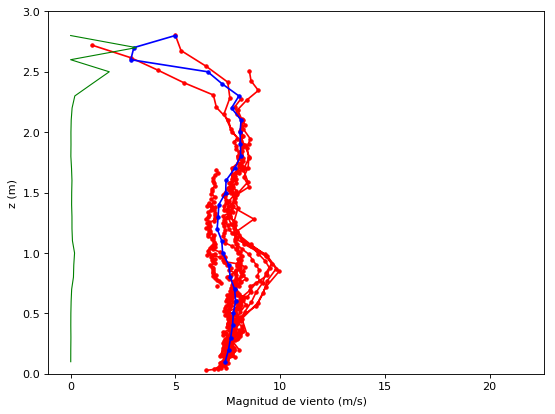

In [15]:
# Gráfico simple para evaluar los resultados cualitativamente

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)
#ax.title('Viento calculado con la elevación %s grados'% nelev)
ax.plot(vad.spd,vad.ht, color='red', marker='.', label='Viento')
ax.plot(totalvad.spd, totalvad.ht, color='blue', marker='.', label='Viento')
ax.plot(totalvad.rmse, totalvad.ht, color='green', linewidth=1.0, linestyle='-', label='RMSE')
plt.ylim([0, maxlev])
ax.set_xlabel('Magnitud de viento (m/s)')
ax.set_ylabel('z (m)')


plt.show()


# Abrimos un sondeo

In [83]:
filename = path_user + 'ANG/ANG/20160105/sondeos/2016010512Z.txt'
sondeo = np.loadtxt(filename)
spd = sondeo[:,7]*0.514444
ht = sondeo[:,1]-191

array([     0.,    250.,    396.,    498.,    554.,    620.,    629.,
          760.,   1352.,   1432.,   1634.,   1789.,   2062.,   2288.,
         2586.,   2642.,   2962.,   3079.,   3511.,   4174.,   5309.,
         5548.,   5609.,   5952.,   6160.,   6390.,   6953.,   7279.,
         7540.,   8065.,   8290.,   8883.,   9339.,   9479.,   9790.,
        10579.,  11153.,  12019.,  12513.,  12582.,  13664.,  13829.,
        14215.,  14349.,  14395.,  14868.,  15223.,  15275.,  15538.,
        16160.,  16279.,  16339.,  16849.,  16876.,  17188.,  17473.,
        17880.,  18085.,  18499.,  18673.,  18762.,  19327.,  19387.,
        19448.,  19530.,  20224.,  20549.,  20805.,  20951.,  21496.,
        21967.,  22273.,  22789.,  23351.,  23410.,  23551.,  23759.,
        23977.,  24157.,  24203.,  24683.,  25202.,  25478.,  25856.,
        26070.,  26389.,  26728.,  26798.,  27469.,  27873.,  28304.,
        29156.,  29805.,  30397.])

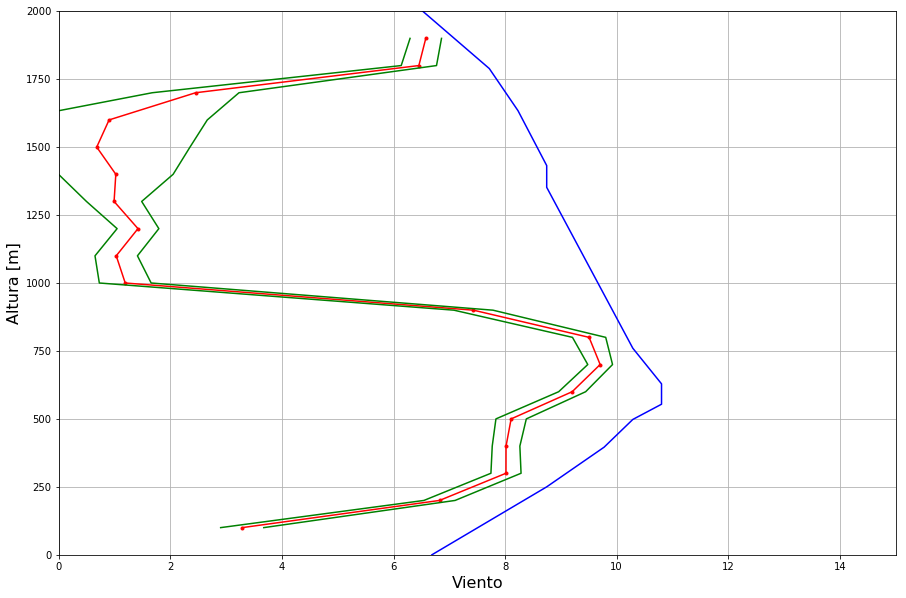

In [84]:
f = plt.figure(figsize = [15,10])
plt.plot(spd,ht,'-b')
plt.plot(totalvad.spd, totalvad.ht*1000, color='red', marker='.', label='Viento')
plt.plot(totalvad.spd+totalvad.rmse, totalvad.ht*1000, color='green', label='Viento')
plt.plot(totalvad.spd-totalvad.rmse, totalvad.ht*1000, color='green', label='Viento')
plt.xlabel('Viento',fontsize='16')
plt.ylabel('Altura [m]',fontsize='16')
plt.xlim([0, 15])
plt.ylim([0, 2000])
#plt.xticks(np.arange(0, 260, 10.0),fontsize='11')
#plt.yticks(np.arange(0, 16, 1.0),fontsize='11')
plt.grid()
plt.show()

In [40]:
#filevad = "20160114_1/elev_vda-2016-01-14T00:00:01Z_INTA_Parana.csv"
path_user = '20160114_2/'
FileList = np.sort(glob.glob(path_user+'elev*'))



for f in range(len(FileList)):
    
    filevad = FileList[f]
    
    DateTime = filevad[20:40]
    
    NameRadar = "INTA_Parana"

    minlev = 0.1  #Nivel inferior en kilometros
    maxlev = 3.0  #Nivel superior en kilometros
    deltalev = 0.1 #Intervalo de la grilla

    # Generamos la grilla del perfil
    pnlevs = ((maxlev - minlev)/deltalev) + 1 #Cantidad de niveles

    pht = np.zeros(shape=(int(pnlevs),))*np.nan
    totalvad = pandas.DataFrame(np.zeros(shape=(int(pnlevs),7))*np.nan, columns = ['ht', 'spd', 'rmse1', 'rmse2', 'rmse3', 'di', 'rings'])
    vad = pandas.read_csv(filevad, sep=";", na_values = -9999.0)

    for l in range(int(pnlevs)):

        pht[l] = minlev + l * deltalev
        upperl = pht[l] + deltalev/2
        lowerl = pht[l] - deltalev/2

        #Subset de los datos que se encuentran en la capa
        temp = vad.loc[(vad.ht >= lowerl) & (vad.ht < upperl) & vad.spd  & (vad.spd.notnull())]
        #Cuento la cantidad de anillos válidos en la capa
        ringpl = len(temp.spd)
        #Calculo el promedio de spd para la capa

        w = temp.rmse + temp.rh
        if not w.any():
            continue

        spd_wavg = np.average(np.asarray(temp.spd), weights=np.asarray(w))
        di_wavg = np.average(np.asarray(temp.di), weights=np.asarray(temp.rh))

        #Calculo el RMSE
        var = sum(np.power(temp.spd-spd_wavg,2)/temp.rmse)/sum(1/temp.rmse)
        rmsec1 = np.sqrt(var/ringpl)
        rmsec2 = np.sqrt(1/(sum(1/np.power(temp.rmse,2))))
        rmsec3 = sum(np.power(temp.spd-spd_wavg,2)/np.sqrt(temp.rmse))/(sum(1/np.sqrt(temp.rmse))*(ringpl-1))

        #Guardo en el dataframe
        totalvad.ht[l] = pht[l]
        totalvad.spd[l] = spd_wavg
        totalvad.rmse1[l] = rmsec1
        totalvad.rmse2[l] = rmsec2
        totalvad.rmse3[l] = rmsec3
        totalvad.di[l] = di_wavg
        totalvad.rings[l] = ringpl
    print DateTime
    #Escribo un .csv que se guarda con la fecha y la hora del volumen de datos
    totalvad.to_csv('20160114_4/vda-'+ DateTime + '_' + NameRadar + '.csv', sep = ';', na_rep = '-9999')


/home/pao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in double_scalars


2016-01-14T00:00:01Z
2016-01-14T00:10:04Z


/home/pao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in double_scalars


2016-01-14T00:20:02Z
2016-01-14T00:30:02Z
2016-01-14T00:40:01Z
2016-01-14T00:50:02Z
2016-01-14T01:00:02Z
2016-01-14T01:10:04Z
2016-01-14T01:20:02Z
2016-01-14T01:30:01Z
2016-01-14T01:40:02Z
2016-01-14T01:50:01Z
2016-01-14T02:00:02Z
2016-01-14T02:10:04Z
2016-01-14T02:20:04Z
2016-01-14T02:30:04Z
2016-01-14T02:40:04Z
2016-01-14T02:50:04Z
2016-01-14T03:00:04Z
2016-01-14T03:10:06Z
2016-01-14T03:20:03Z
2016-01-14T03:30:04Z
2016-01-14T03:40:04Z
2016-01-14T03:50:04Z
2016-01-14T04:00:04Z
2016-01-14T04:10:07Z
2016-01-14T04:20:04Z
2016-01-14T04:30:04Z
2016-01-14T04:40:04Z
2016-01-14T04:50:04Z
2016-01-14T05:00:04Z
2016-01-14T05:10:07Z
2016-01-14T05:20:04Z
2016-01-14T05:30:05Z
2016-01-14T05:40:04Z
2016-01-14T05:50:04Z
2016-01-14T06:00:05Z
2016-01-14T06:20:05Z
2016-01-14T06:30:04Z
2016-01-14T06:40:05Z
2016-01-14T06:50:05Z
2016-01-14T07:00:04Z
2016-01-14T07:10:07Z
2016-01-14T07:20:05Z
2016-01-14T07:30:05Z
2016-01-14T07:50:05Z
2016-01-14T08:00:05Z
2016-01-14T08:10:08Z
2016-01-14T08:20:06Z
2016-01-14T08

In [38]:
path_user = '20160114_1/'
FileList = np.sort(glob.glob(path_user+'elev*'))
File = FileList[2]
vad = pandas.read_csv(filevad, sep=";", na_values = -9999.0)
DateTime = File[20:40]
vad

,Unnamed: 0,a,b,di,elev,ht,rh,rmse,spd
0,0,NaN,NaN,NaN,0.5,0.002185,0.249990,NaN,NaN
1,1,NaN,NaN,NaN,0.5,0.006578,0.749971,NaN,NaN
2,2,NaN,NaN,NaN,0.5,0.011000,1.249952,NaN,NaN
3,3,NaN,NaN,NaN,0.5,0.015452,1.749933,NaN,NaN
4,4,NaN,NaN,NaN,0.5,0.019933,2.249914,NaN,NaN
5,5,NaN,NaN,NaN,0.5,0.024443,2.749895,NaN,NaN
6,6,NaN,NaN,NaN,0.5,0.028983,3.249876,NaN,NaN
7,7,NaN,NaN,NaN,0.5,0.033552,3.749857,NaN,NaN
8,8,NaN,NaN,NaN,0.5,0.038151,4.249838,NaN,NaN
9,9,NaN,NaN,NaN,0.5,0.042779,4.749819,NaN,NaN
